# Information transfer

The SARS-CoV-2 and human protein interactions are treated as information sources. Each edge in the pathway network 
is treated as a binary symmetric information channel. Initial state of the network is all network nodes at maximum entropy state. The information source nodes are fixed at low entropy state. Information propagates through the network edges (information channels) to the other nodes (receiver nodes) of the network. We use relative entropy of the receiver nodes as a measure of impact of the SARS-CoV-2 proteins.

In [1]:
import os, sys
import numpy as np
import scipy as sp
import pandas as pd
import copy as copy
from tqdm.notebook import tqdm
import math
import scipy.stats as st

from CoRe import reader
from CoRe.ncip import ncip
from CoRe.BA_C import BA

import importlib

import networkx as nx
import matplotlib.pyplot as plt
import json

In [2]:
current_directory = os.getcwd()

data_directory = current_directory + "/Examples"
os.chdir(data_directory)

f = open('SARS_CoV2-interactions.json')
all_SARS_nodes = json.load(f)
f.close()

sars_pnames = list(all_SARS_nodes)

In [3]:
selected_pathway = 'Immune System'
pathway_nametag = selected_pathway.replace(' ','_')

network_type = 'medium-PPI'

data_directory = current_directory + "/Examples/" + pathway_nametag
os.chdir(data_directory)

edge_data = pd.read_pickle(pathway_nametag+'_'+network_type+'-edges.pkl')
node_data = pd.read_pickle(pathway_nametag+'_'+network_type+'-nodes.pkl')

In [4]:
remake_graph = False

if remake_graph==False:
    netObj = ncip()
    netObj.load_graph(pathway_nametag+"-"+network_type+".gml")
else:
    netObj = ncip()
    netObj.load_data(edge_data,node_data)
    netObj.make_graph()
    netObj.save_network(pathway_nametag,network_type)

In [5]:
f = open('SARS_CoV2-'+pathway_nametag+'_interactions.json')
SARS_nodes = json.load(f)
f.close()

**Construction of the information channel model for the network.**

$\rho$ is the communication error for each edge. If a node receives input from multiple edges, the receiver state is the mean of the individual output states. The default channel type is a binary symmetric channel as defined in [Elements of information theory](https://books.google.com/books?hl=en&lr=&id=VWq5GG6ycxMC&oi=fnd&pg=PR15&ots=bZ6fK1WaYP&sig=g2JGYtx-EFJKhoFBG-THaWLfKY0#v=onepage&q&f=false).

In [6]:
initial_state_type = 'low'

errorname = '0.0'
rho = float(errorname)

input_bits = 1
code_length = int(2**input_bits)

max_entropy_state = (1.0/float(code_length))*np.ones(shape=(code_length,))

low_state = np.zeros(shape=(code_length,))
low_state[-1] = 1.0

high_state = np.zeros(shape=(code_length,))
high_state[0] = 1.0

if initial_state_type=='high':
    initial_state = high_state
elif initial_state_type=='low':
    initial_state = low_state
else:
    initial_state = max_entropy_state

print(high_state,low_state)

netObj.construct_C(rho,h=input_bits,neglect_modules=[])
node_list = list(netObj.G_d.nodes)

[1. 0.] [0. 1.]


**Initial and boundary conditions for information propagation**

The state of each node is define by the binary probability state $\{P(n=1),P(n=0)\}$, where the abundance (or copy number) the physical entity (n) is coarse-grained into a binary variable high (1) or low (0). The maximum entropy state for each node is $\{0.5,0.5\}$. We set every node in the network initially at the maximum entropy state. 

We assume that direct interaction with SARS-CoV-2 proteins reduces the effective abundance of the associated network nodes, so we set the state of these nodes at $\{0,1\}$. Additionally, we set the state of ATP, ADP, and Pi at the maximum entropy state $\{0.5,0.5\}$.

**Additional sources nodes to specify for information transfer**

In [7]:
additional_source_nodes = []

**Disconnect all drug nodes from the network, we only use them while screening therapies**

In [8]:
netObj.disconnect_drug_nodes()

In [9]:
topological_source_count = 0

for nG in netObj.G_d.nodes():
    if netObj.G_d.in_degree(nG)==0:
        topological_source_count += 1

In [10]:
initial_network_state = np.zeros(shape=(netObj.C_sparse.shape[0],1))
network_sources = {}

for n in range(0,len(node_list)):
    initial_network_state[code_length*n:code_length*(n+1),0] = initial_state
    
network_sources = []

reference_final_state, steps = netObj.get_final_state(initial_network_state,[])
reference_final_entropy = netObj.state_entropy(reference_final_state,[])
print('Reference state relative entropy: ',reference_final_entropy)

Reference state relative entropy:  443.53300763777236


In [11]:
network_state = {}
network_sources = {}

for k in tqdm(SARS_nodes.keys()):
    network_state[k] = np.zeros(shape=(netObj.C_sparse.shape[0],1))
    
    for n in range(0,len(node_list)):
        network_state[k][code_length*n:code_length*(n+1),0] = initial_state
    
    network_sources[k] = []
    
    for n in SARS_nodes[k]:
        try:
            i = node_list.index(n)

            network_state[k][netObj.code_length*i:netObj.code_length*(i+1),0] = low_state

            network_sources[k].append(i)
        except ValueError:
            pass
        
    for n in additional_source_nodes:
        try:
            i = node_list.index(n)

            network_state[k][netObj.code_length*i:netObj.code_length*(i+1),0] = high_state

            network_sources[k].append(i)
        except ValueError:
            pass
        
    print(k,len(network_sources[k]),len(node_list)-len(network_sources[k])-topological_source_count)

  0%|          | 0/17 [00:00<?, ?it/s]

SARS-CoV2 Nsp2 1 2940
SARS-CoV2 Nsp7 2 2939
SARS-CoV2 Nsp8 1 2940
SARS-CoV2 Nsp10 0 2941
SARS-CoV2 Nsp12 1 2940
SARS-CoV2 Nsp13 1 2940
SARS-CoV2 Nsp14 1 2940
SARS-CoV2 Nsp15 1 2940
SARS-CoV2 Spike 0 2941
SARS-CoV2 ORF3a 1 2940
SARS-CoV2 E 0 2941
SARS-CoV2 M 1 2940
SARS-CoV2 ORF8 4 2937
SARS-CoV2 ORF9b 1 2940
SARS-CoV2 ORF9c 2 2939
SARS-CoV2 N 0 2941
SARS-CoV2 ORF10 2 2939


**Relative entropy of the total network and number of steps to stationary state.**

In [12]:
entropy_data = pd.DataFrame(columns=['SARS-CoV-2 protein','Entropy (bits)','Steps'])
final_state = {}
final_entropy = {}

try:
    os.chdir(data_directory+'/final_network_state')
except OSError:
    os.mkdir(data_directory+'/final_network_state')
    os.chdir(data_directory+'/final_network_state')

#for k in tqdm(SARS_nodes.keys()):
for k in tqdm(sars_pnames):
    try:
        final_state[k], steps = netObj.get_final_state(network_state[k],network_sources[k])
        #final_entropy[k] = reference_final_entropy - netObj.state_entropy(final_state[k],network_sources[k])
        final_entropy[k] = netObj.state_entropy(final_state[k],network_sources[k],reference_final_state)
        
        df_temp = pd.DataFrame([[k,final_entropy[k],steps]],columns=['SARS-CoV-2 protein','Entropy (bits)','Steps'])
        
        entropy_data = pd.concat([entropy_data,df_temp],sort=False)
        
    except KeyError:
        final_state[k] = reference_final_state
        final_entropy[k] = 0.0
        
        df_temp = pd.DataFrame([[k,0.0,0.0]],columns=['SARS-CoV-2 protein','Entropy (bits)','Steps'])
        
        entropy_data = pd.concat([entropy_data,df_temp],sort=False)
        
output_filename = initial_state_type+'-'+pathway_nametag+'_'+network_type+'_'+'relative_entropy-'+errorname+'.csv'

entropy_data.to_csv(output_filename,index=None)
os.chdir(data_directory)

  0%|          | 0/28 [00:00<?, ?it/s]

Relative entropy of the network induced by the interaction with the SARS-CoV-2 protiens


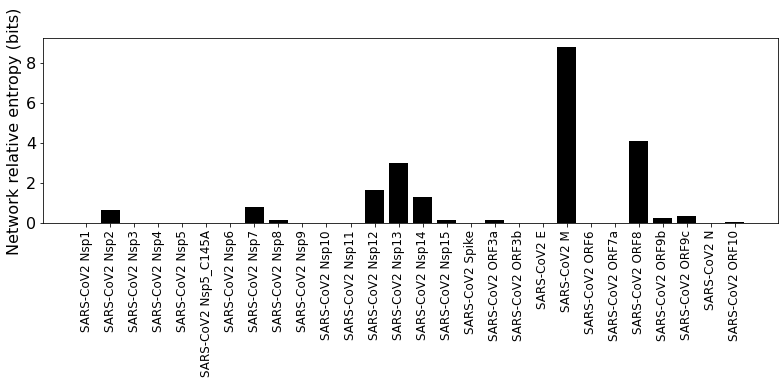

In [13]:
print('\033[1m'+'Relative entropy of the network induced by the interaction with the SARS-CoV-2 protiens')

fig = plt.figure(figsize=(11,5))
plt.bar(entropy_data['SARS-CoV-2 protein'].to_numpy(),entropy_data['Entropy (bits)'].to_numpy(),color='black')
#plt.yscale('log')
#plt.ylim(0,20)
plt.ylabel('Network relative entropy (bits)',size=16)
plt.tick_params(axis='y',labelsize=16)
plt.tick_params(axis='x',labelsize=12,rotation=90)

plt.tight_layout()

In [14]:
node_list = netObj.G_d.nodes.data()

total_genomic_entities = np.sum([x[1]['sequenced'] for x in node_list])

genome_indices = [i for x,i in zip(node_list,range(0,len(node_list))) if x[1]['sequenced']!=0]

print(total_genomic_entities,len(genome_indices))

1131 1131


**Identify reference gene products that receive information about the SARS-CoV-2 proteins.** 

We use relative entropy with respect to the maximum entropy state as a measure of the amount of information received by a network node, $H_M(n)=\sum_{k\in\{0,1\}} P(n=k)\log_2 P(n=k)/0.5$. The nodes that have relative entropy above a threshold, $H_M(n)\geq \alpha$, are identified as receiving considerable amount of information. We chose $\alpha=0.1$ bits because we found in experimental measurements of gene expression data, it is challenging to measure the mutual information with a precision higher than 0.1 bits.

In [15]:
relH_threshold = 1e-2

local_entropies = {}
local_entropies_mat = np.zeros(shape=(total_genomic_entities,len(list(SARS_nodes.keys()))))
max_entropy_state = np.array([0.5,0.5])
    
j = 0

for k in SARS_nodes.keys():
    local_entropies[k] = np.zeros(shape=(total_genomic_entities,))
    
    for i in range(0,len(genome_indices)):
        gen_i = genome_indices[i]
        
        if len(network_sources[k])>0 and gen_i not in network_sources[k]:
            this_state = final_state[k][netObj.code_length*gen_i:netObj.code_length*(gen_i+1),0]
            ref_state = reference_final_state[netObj.code_length*gen_i:netObj.code_length*(gen_i+1),0]
            
            local_entropies[k][i] = st.entropy(this_state,ref_state,base=2)
            
            if local_entropies[k][i]<relH_threshold:
                local_entropies[k][i] = 0.0
        
    local_entropies_mat[:,j] = local_entropies[k]
    
    j += 1

**Identify reference gene products that have relative entropy higher than the threshold.**

In [16]:
n_names = [x[0] for x in node_list]
gen_names = []

for i in genome_indices:
    gen_names.append(n_names[i])

Drop SARS-CoV-2 proteins that cause lower than threshold relative entropy to reference gene products.

In [17]:
df = pd.DataFrame(local_entropies_mat,columns=list(SARS_nodes.keys()))
df.insert(0,"node_index",genome_indices)
df.insert(0,"node_ids",gen_names)

arr = df.to_numpy()

zero_r_idx, zero_c_names = [], []

for i in range(0,arr.shape[0]):
    if np.sum(arr[i,2:])==0:
        zero_r_idx.append(i)
        
c_names = list(df)

for j in range(0,arr.shape[1]):
    if np.sum(arr[:,j])==0:
        zero_c_names.append(c_names[j])

df_reduced1 = df.drop(zero_r_idx)
df_reduced = df_reduced1.drop(zero_c_names,axis=1)

os.chdir(data_directory)

df_reduced.to_csv(initial_state_type+'-'+'SARS_CoV2_Immune_System_medium-PPI_affected_genes'+errorname+'.csv',index=None)